## Notebook for generating and expanding the dataset

In [ ]:
import numpy as np 
import cv2
from matplotlib import pyplot as plt
import os



DS_path = "/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train"
Generated_img_path = "/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/generated" # add generated!
os.makedirs(f"{Generated_img_path}", exist_ok=True)

np.random.seed(100)

**Data format:**
{
      "image_id": "L1000793.jpeg",
      "width": 4000,
      "height": 3000,
      "annotations": [
        12 0.520617 0.203704 0.104938 0.166667
        10 0.682963 0.350926 0.096296 0.142593
        10 0.338518 0.734259 0.096296 0.135185
        6 0.373704 0.395370 0.070370 0.131481
        6 0.618765 0.662963 0.079012 0.137037
        7 0.478642 0.537963 0.102469 0.157407
      ]
    }

**Wanted transformations**

- Add noise (no change needed in bboxes)
- Rotations (needed change in bboxes)
- Translations (needed change in bboxes)
- Resizing (small) (change in bboxes)
- Slight color changes (no change in bboxes)
- Slight perspective warp ((needed chnage in bboxes))


In [60]:
class AnnotatedImage:
    def __init__(self, image_path, bboxes, labels, width, height):
        """
        Args:
            image_path (str): Path to the image file.
            bboxes (List[List[int]]): List of bounding boxes in [x_min, y_min, x_max, y_max] format.
            labels (List[int]): List of class indices corresponding to the bboxes.
        """
        self.image_path = image_path
        self.bboxes = bboxes  # List of [x_min, y_min, x_max, y_max] # img percentages
        self.labels = labels  # List of class indices
        self.width = width
        self.height = height

    def __repr__(self):
        filename = os.path.basename(self.image_path)
        box_str = ", ".join([f"{box}" for box in self.bboxes])
        return f"AnnotatedImage(file='{filename}', boxes=[{box_str}])"
    
# test image in correct format
img = AnnotatedImage("L1000756.JPG",
                     [[0.520617,0.203704,0.104938,0.166667]],
                     [12],
                     6000,
                     4000
                     )

In [65]:
def show_images(images, titles=None, figsize=(15, 5)):
    """
    Display one or multiple images in a row with optional titles.

    Args:
        images (np.ndarray or List[np.ndarray]): Image or list of images (BGR or RGB, dtype uint8).
        titles (List[str], optional): Titles for the images.
        figsize (tuple): Figure size for matplotlib.
    """
    if not isinstance(images, list):
        images = [images]
    if titles is None:
        titles = ["" for _ in images]
    
    plt.figure(figsize=figsize)
    
    for i, (img, title) in enumerate(zip(images, titles)):
        if img.ndim == 3 and img.shape[2] == 3:
            # Assume BGR and convert to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif img.ndim == 2:
            pass  # grayscale
        else:
            raise ValueError("Image must be 2D (grayscale) or 3D with 3 channels (BGR).")
        
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def show_image_with_boxes(img_class, ds_path1 = DS_path, ds_path2 = Generated_img_path, color=(0, 255, 0), thickness=2):
    """
    Displays an image with YOLO-format bounding boxes overlaid.
    Tries two possible base directories to find the image.

    Args:
        img_class (AnnotatedImage): The image object with normalized YOLO boxes.
        ds_path1 (str): First base path to look for the image.
        ds_path2 (str): Second base path to look for the image.
        color (tuple): BGR color of bounding box.
        thickness (int): Thickness of the bounding box lines.
    """
    # Try both directories
    full_path1 = os.path.join(ds_path1, img_class.image_path)
    full_path2 = os.path.join(ds_path2, img_class.image_path)

    if os.path.exists(full_path1):
        full_path = full_path1
    elif os.path.exists(full_path2):
        full_path = full_path2
    else:
        raise FileNotFoundError(f"Image not found in either path:\n{full_path1}\n{full_path2}")

    # Load image
    img = cv2.imread(full_path)
    if img is None:
        raise ValueError(f"Image could not be read at: {full_path}")

    h, w = img_class.height, img_class.width

    # Draw bounding boxes
    for bbox in img_class.bboxes:
        x_center, y_center, bw, bh = bbox
        x_min = int((x_center - bw / 2) * w)
        y_min = int((y_center - bh / 2) * h)
        x_max = int((x_center + bw / 2) * w)
        y_max = int((y_center + bh / 2) * h)

        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)

    # Convert BGR to RGB and show
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(os.path.basename(img_class.image_path))
    plt.axis('off')
    plt.show()

### NOISE

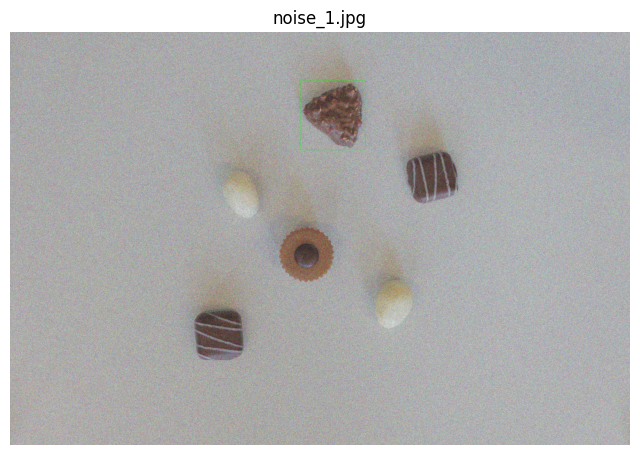

In [82]:
def add_noise(img_class, noise_const=15, save_dir=Generated_img_path):
    """
    Adds Gaussian noise to an image and saves it with a unique name.

    Args:
        img_class (AnnotatedImage): Input annotated image object.
        noise_const (float): Standard deviation of the Gaussian noise.
        save_dir (str): Directory where to save the noisy image.

    Returns:
        AnnotatedImage: New object with updated image path and same annotations.
    """
    # Load image
    img = cv2.imread(f"{DS_path}/{img_class.image_path}")
    if img is None:
        raise FileNotFoundError(f"Image not found: {DS_path}/{img_class.image_path}")
    if img.dtype != np.uint8:
        raise ValueError("Input image must be of type uint8.")

    # Add noise
    img_float = img.astype(np.float32)
    noise = np.random.normal(0, noise_const, img.shape).astype(np.float32)
    noisy_img = np.clip(img_float + noise, 0, 255).astype(np.uint8)

    # Find next available filename: noise_1.jpg, noise_2.jpg, ...
    existing = [f for f in os.listdir(save_dir) if f.startswith("noise_") and f.endswith(".jpg")]
    next_index = 1 + max(
        [int(f.split("_")[1].split(".")[0]) for f in existing] or [0]
    )
    filename = f"noise_{next_index}.jpg"
    filepath = os.path.join(save_dir, filename)

    # Save noisy image
    cv2.imwrite(filepath, noisy_img)

    # Create new AnnotatedImage object (assuming you’ve added width/height)
    return AnnotatedImage(
        image_path=filepath,
        bboxes=img_class.bboxes,
        labels=img_class.labels,
        width=img_class.width,
        height=img_class.height
    )

noisy_img_class = add_noise(img, noise_const=100)
show_image_with_boxes(noisy_img_class)

### Rotations

In [63]:
def denormalize_box(box, img_w, img_h):
    """Convert normalized box to pixel-space [x_min, y_min, x_max, y_max]."""
    cx, cy, w, h = box
    x_min = int((cx - w / 2) * img_w)
    y_min = int((cy - h / 2) * img_h)
    x_max = int((cx + w / 2) * img_w)
    y_max = int((cy + h / 2) * img_h)
    return [x_min, y_min, x_max, y_max]

def normalize_box(box, img_w, img_h):
    """Convert pixel-space [x_min, y_min, x_max, y_max] to normalized center format."""
    x_min, y_min, x_max, y_max = box
    cx = ((x_min + x_max) / 2) / img_w
    cy = ((y_min + y_max) / 2) / img_h
    w = (x_max - x_min) / img_w
    h = (y_max - y_min) / img_h
    return [cx, cy, w, h]

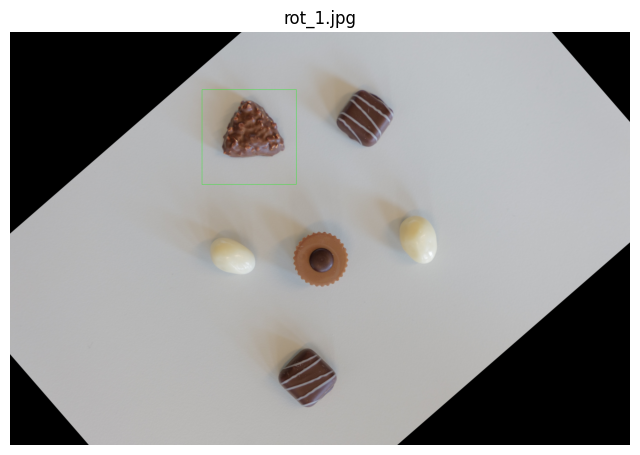

In [81]:
def rotate_image_and_boxes(img_class, angle, save_dir=Generated_img_path):
    """
    Rotates an image and its normalized bounding boxes.

    Args:
        img_class (AnnotatedImage): The input image and annotations.
        angle (float): Rotation angle in degrees (positive = counter-clockwise).
        save_dir (str): Directory to save the rotated image.

    Returns:
        AnnotatedImage: New rotated image + updated normalized boxes.
    """
    # Load image    
    img = cv2.imread(f"{DS_path}/{img_class.image_path}")
    h, w = img.shape[:2]
    center = (w // 2, h // 2)

    # Rotate image using warpAffine
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale=1.0)
    rotated_img = cv2.warpAffine(img, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR)

    # Update bounding boxes
    new_boxes = []
    for box in img_class.bboxes:
        # Convert normalized box to corner pixel coords
        x_min, y_min, x_max, y_max = denormalize_box(box, w, h)
        corners = np.array([
            [x_min, y_min],
            [x_max, y_min],
            [x_max, y_max],
            [x_min, y_max]
        ])  # shape (4, 2)

        # Add ones to corners for affine transform
        ones = np.ones((4, 1))
        corners_hom = np.hstack([corners, ones])  # shape (4, 3)

        # Rotate corners
        rotated_corners = rotation_matrix @ corners_hom.T  # shape (2, 4)
        rotated_corners = rotated_corners.T  # shape (4, 2)

        # Get new bounding box
        x_coords, y_coords = rotated_corners[:, 0], rotated_corners[:, 1]
        x_min_r, x_max_r = max(0, x_coords.min()), min(w, x_coords.max())
        y_min_r, y_max_r = max(0, y_coords.min()), min(h, y_coords.max())

        # Normalize back
        new_box = normalize_box([x_min_r, y_min_r, x_max_r, y_max_r], w, h)
        new_boxes.append(new_box)

    # Save image
    existing = [f for f in os.listdir(save_dir) if f.startswith("rot_") and f.endswith(".jpg")]
    next_index = 1 + max([int(f.split("_")[1].split(".")[0]) for f in existing] or [0])
    filename = f"rot_{next_index}.jpg"
    filepath = os.path.join(save_dir, filename)
    cv2.imwrite(filepath, rotated_img)

    return AnnotatedImage(
        image_path=filepath,
        bboxes=new_boxes,
        labels=img_class.labels,
        width=w,
        height=h
    )

rot =rotate_image_and_boxes(img, 41)

show_image_with_boxes(rot)

#/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/L1000756.JPG

### Translation

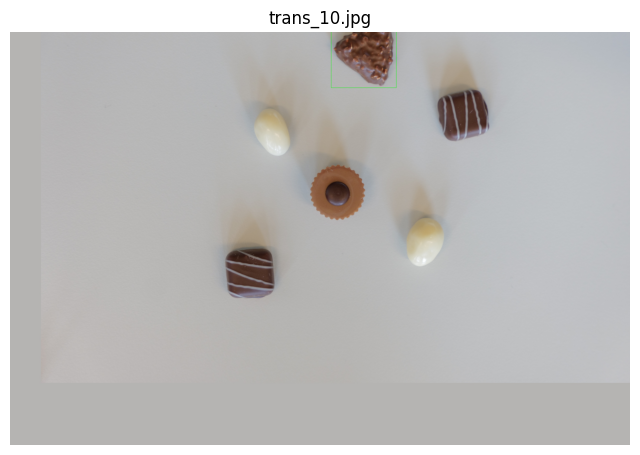

In [ ]:
def translate_image_and_boxes(img_class, x_shift, y_shift, save_dir):
    """
    Translates an image and updates its YOLO-format bounding boxes.

    Args:
        img_class (AnnotatedImage): The image and its annotations.
        x_shift (int): Horizontal translation in pixels (positive = right).
        y_shift (int): Vertical translation in pixels (positive = down).
        save_dir (str): Directory to save the translated image.

    Returns:
        AnnotatedImage: New image with updated boxes.
    """
    # Load image
    full_path = os.path.join(DS_path, img_class.image_path)
    img = cv2.imread(full_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {full_path}")
    
    h, w = img_class.height, img_class.width

    # Compute mean color and create padding background
    mean_color = tuple(map(int, img.mean(axis=(0, 1))))

    # Translation matrix
    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    translated_img = cv2.warpAffine(img, M, (w, h), borderValue=mean_color)

    # Save image
    existing = [f for f in os.listdir(save_dir) if f.startswith("trans_") and f.endswith(".jpg")]
    next_index = 1 + max([int(f.split("_")[1].split(".")[0]) for f in existing] or [0])
    filename = f"trans_{next_index}.jpg"
    filepath = os.path.join(save_dir, filename)
    cv2.imwrite(filepath, translated_img)

    # Update bounding boxes (YOLO format)
    new_bboxes = []
    for box in img_class.bboxes:
        cx, cy, bw, bh = box
        new_cx = (cx * w + x_shift) / w
        new_cy = (cy * h + y_shift) / h
        #! HERE WE NEED TO FIGURE OUT WHAT WORKS BEST, WHEN TO DISCARD BBoxes
        threshold = 0.75  # percent of box that must be visible

        x_left = new_cx - bw / 2
        x_right = new_cx + bw / 2
        y_top = new_cy - bh / 2
        y_bottom = new_cy + bh / 2

        visible_x = max(0, min(x_right, 1) - max(x_left, 0))
        visible_y = max(0, min(y_bottom, 1) - max(y_top, 0))
        visible_area = visible_x * visible_y
        total_area = bw * bh

        if total_area > 0 and (visible_area / total_area) >= threshold:
            new_bboxes.append([new_cx, new_cy, bw, bh])

    return AnnotatedImage(
        image_path=filename,
        bboxes=new_bboxes,
        labels=img_class.labels[:len(new_bboxes)],  # Keep only matching labels
        width=w,
        height=h
    )

translated = translate_image_and_boxes(img, x_shift=300, y_shift=-600, save_dir=Generated_img_path)
show_image_with_boxes(translated)